## Importacion de librerías

In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import cv2
import os
import random
import numpy as np
from tqdm import tqdm

c:\Users\sergi\PYTHON files\MIOTI\02-99 TFM Deep Learning\.venv_TFM_DL\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# 📂 Rutas
INPUT_FOLDER = "./outfits_procesados_1024_rgb/"
OUTPUT_FOLDER = "./outfits_augmented_1024_rgb/"

# Crear carpeta de salida si no existe
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# 📑 Lista de imágenes originales
image_files = [f for f in os.listdir(INPUT_FOLDER) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"🔍 Encontradas {len(image_files)} imágenes en '{INPUT_FOLDER}'")

🔍 Encontradas 1485 imágenes en './outfits_procesados_1024_rgb/'


In [3]:
TARGET_IMAGES = 50000  # Número de imágenes objetivo
TARGET_IMAGES_PER_ORIGINAL = TARGET_IMAGES // len(image_files) + 1 # Número de imágenes por original

print(f"Se quieren obtener mínimo {TARGET_IMAGES} imágenes nuevas.")
print(f"Se generarán {TARGET_IMAGES_PER_ORIGINAL} imágenes por cada imagen original.")
print(f"Total de imágenes nuevas que se crearan: {len(image_files)} x {TARGET_IMAGES_PER_ORIGINAL} = {len(image_files) * TARGET_IMAGES_PER_ORIGINAL}.")

Se quieren obtener mínimo 50000 imágenes nuevas.
Se generarán 34 imágenes por cada imagen original.
Total de imágenes nuevas que se crearan: 1485 x 34 = 50490.


## Código para una sola imagen

Forma de la imagen cargada (BGRA): (1024, 1024, 3)


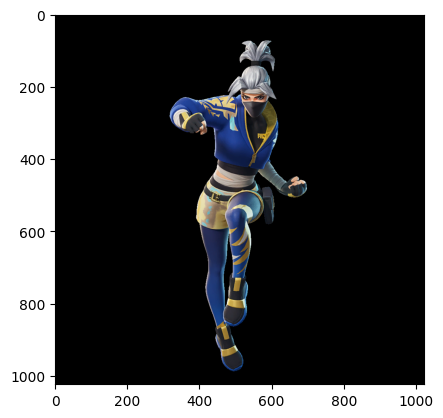

In [4]:
# --- Código para preprocesar la imagen limpiando los fondos ---
input_path = os.path.join(INPUT_FOLDER, image_files[14])
output_path = os.path.join(OUTPUT_FOLDER, image_files[14])

# 1. Cargar la imagen manteniendo todos los canales (incluido el alfa)
image_bgr = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)

if image_bgr is None:
    print(f"Error: No se pudo cargar la imagen en {input_path}")
else:
    print(f"Forma de la imagen cargada (BGRA): {image_bgr.shape}")
    
    # Convertir la imagen a RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    # Ver la imagen original
    plt.imshow(image_rgb)
    plt.show()


In [5]:
image_rgb[700, 480]

array([0, 0, 0], dtype=uint8)

In [6]:
# --- Función is_grounded ---
def is_grounded(image, num_rows_to_check=5):
    """
    Verifica si una imagen está "pegada al suelo" comprobando si las últimas N filas
    son predominantemente negras.

    Args:
        image (np.array): La imagen en formato RGB.
        num_rows_to_check (int): Número de filas inferiores a verificar.

    Returns:
        bool: True si el personaje parece estar tocando el "suelo" (no hay mucho negro abajo),
            False en caso contrario.
    """

    height = image.shape[0]

    # Seleccionar las últimas `num_rows_to_check` filas
    bottom_rows = image[height - num_rows_to_check:height, :, :]

    # Contar píxeles negros (0,0,0) en estas filas
    # Un píxel es negro si todos sus canales son 0
    black_pixels_mask = np.all(bottom_rows == [0, 0, 0], axis=-1)
    num_black_pixels = np.sum(black_pixels_mask)

    total_pixels_in_bottom_rows = bottom_rows.shape[0] * bottom_rows.shape[1]

    # Lógica: Si la proporción de píxeles NO negros en la parte inferior es significativa,
    # entonces el personaje está "grounded".
    # Por lo tanto, si la proporción de píxeles NEGROS es BAJA, está grounded.
    proportion_black = num_black_pixels / total_pixels_in_bottom_rows
    
    # Si MENOS del X% de los píxeles inferiores son negros, asumimos que el personaje está ahí.
    # Ejemplo: si menos del 70% de los píxeles inferiores son negros, está "grounded".
    # Ajusta este `grounded_threshold_black_proportion` según tus necesidades.
    # Si casi todo es negro (e.g., >98% negro), entonces NO está grounded.
    if proportion_black > 0.98:
        return False # No hay personaje en la parte inferior
    else:
        return True # Hay personaje en la parte inferior

In [7]:
# --- Función is_ceiled ---
def is_ceiled(image, num_rows_to_check=5):
    """
    Verifica si un personaje en una imagen está "pegado al techo" comprobando
    si las primeras N filas son predominantemente negras.

    Args:
        image (np.array): La imagen en formato RGB.
        num_rows_to_check (int): Número de filas superiores a verificar.

    Returns:
        bool: True si el personaje parece estar tocando el "techo" (no hay mucho negro arriba),
            False en caso contrario.
    """

    height = image.shape[0]

    # Seleccionar las primeras `num_rows_to_check` filas
    top_rows = image[0:num_rows_to_check, :, :]

    # Contar píxeles negros (0,0,0) en estas filas
    # Un píxel es negro si todos sus canales son 0
    black_pixels_mask = np.all(top_rows == [0, 0, 0], axis=-1)
    num_black_pixels = np.sum(black_pixels_mask)

    total_pixels_in_top_rows = top_rows.shape[0] * top_rows.shape[1]

    proportion_black = num_black_pixels / total_pixels_in_top_rows
    
    # Lógica: Si la proporción de píxeles negros en la parte SUPERIOR es BAJA,
    # entonces el personaje está "ceiled" (pegado al techo).
    if proportion_black > 0.98:
        return False # No hay personaje en la parte superior
    else:
        return True # Hay personaje en la parte superior

In [12]:
# --- Función de Aumentación ---
def augment_and_save_images(
    image_file_path,
    image_bgr,
    OUTPUT_FOLDER,
    target_images_augmentations=35,
    debug=False
):
    """
    Genera aumentaciones y guarda la original y las aumentadas.
    """

    # --- Definición de Transformaciones de Color ---
    color_transforms = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.75),
        A.HueSaturationValue(hue_shift_limit=(-5, 5), p=0.6),
        A.RGBShift(r_shift_limit=(-10, 10), g_shift_limit=(-10, 10), b_shift_limit=(-10, 10), p=0.5),
    ])

    # --- Definición de Pipelines Geométricos ---
    geometric_transforms_standard = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Affine(
            translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)},
            scale=(0.9, 1.1),
            rotate=(-10, 10),
            interpolation=cv2.INTER_LINEAR,
            border_mode=cv2.BORDER_CONSTANT,
            fill=(0,0,0),
            p=1.0
        ),
    ])

    geometric_transforms_grounded = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Affine(
            translate_percent={'x': (-0.1, 0.1), 'y': (0, 0.1)},
            scale=(1.0, 1.1),
            rotate=0,
            interpolation=cv2.INTER_LINEAR,
            border_mode=cv2.BORDER_CONSTANT,
            fill=(0,0,0),
            p=1.0
        ),
    ])
    
    is_grounded_flag = is_grounded(image_bgr)
    print(f"Imagen '{image_file_path}' está grounded: {is_grounded_flag}") if debug else None
    is_ceiled_flag = is_ceiled(image_bgr)
    print(f"Imagen '{image_file_path}' original está ceiled:", is_ceiled_flag) if debug else None
    if (is_grounded_flag or is_ceiled_flag):
        active_geometric_transforms = geometric_transforms_grounded
    else:
        active_geometric_transforms = geometric_transforms_standard

    initial_background_mask = np.all(image_bgr == [0, 0, 0], axis=-1)

    counter = 0
    while counter < target_images_augmentations:
        current_image = image_bgr.copy()
        transformed_color = color_transforms(image=current_image)
        image_after_color_change = transformed_color['image']
        image_after_color_change[initial_background_mask] = [0, 0, 0]
        
        augmented = active_geometric_transforms(image=image_after_color_change)
        augmented_image = augmented['image']
        
        # Si la imagen está "ceiled", no la guardamos
        is_ceiled_flag = is_ceiled(augmented_image)
        print(f"Imagen '{image_file_path}' está ceiled:", is_ceiled_flag) if debug else None
        if is_ceiled_flag:
            print(f"Imagen '{image_file_path}' descartada porque está ceiled.") if debug else None
            continue
        counter += 1
        
        # Nombre de archivo para la aumentación: base_nombre_XX.png
        base_name = os.path.splitext(os.path.basename(image_file_path))[0]
        sufijo = f"{counter:02d}"
        output_path = os.path.join(
            OUTPUT_FOLDER,
            f"{base_name}_{sufijo}.png"
        )
        cv2.imwrite(output_path, augmented_image)


In [13]:
# --- Código para preprocesar la imagen limpiando los fondos ---
input_path = os.path.join(INPUT_FOLDER, image_files[14])
output_path = os.path.join(OUTPUT_FOLDER, image_files[14])

# 1. Cargar la imagen manteniendo todos los canales (incluido el alfa)
image_bgr = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)

augment_and_save_images(
    image_files[14],
    image_bgr,
    OUTPUT_FOLDER,
    target_images_augmentations=TARGET_IMAGES_PER_ORIGINAL,
    debug=True
)

Imagen 'Character_BandageNinjaFNCS_1024_3c.png' está grounded: False
Imagen 'Character_BandageNinjaFNCS_1024_3c.png' original está ceiled: False
Imagen 'Character_BandageNinjaFNCS_1024_3c.png' está ceiled: False
Imagen 'Character_BandageNinjaFNCS_1024_3c.png' está ceiled: False
Imagen 'Character_BandageNinjaFNCS_1024_3c.png' está ceiled: False
Imagen 'Character_BandageNinjaFNCS_1024_3c.png' está ceiled: False
Imagen 'Character_BandageNinjaFNCS_1024_3c.png' está ceiled: False
Imagen 'Character_BandageNinjaFNCS_1024_3c.png' está ceiled: False
Imagen 'Character_BandageNinjaFNCS_1024_3c.png' está ceiled: False
Imagen 'Character_BandageNinjaFNCS_1024_3c.png' está ceiled: False
Imagen 'Character_BandageNinjaFNCS_1024_3c.png' está ceiled: True
Imagen 'Character_BandageNinjaFNCS_1024_3c.png' descartada porque está ceiled.
Imagen 'Character_BandageNinjaFNCS_1024_3c.png' está ceiled: False
Imagen 'Character_BandageNinjaFNCS_1024_3c.png' está ceiled: False
Imagen 'Character_BandageNinjaFNCS_1024_

## Código para todas las imágenes del dataset

In [14]:
for img_file in tqdm(image_files, desc="Augmentando skins"):
    # Cargar la imagen original
    img_path = os.path.join(INPUT_FOLDER, img_file)
    image_bgr = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

    # Verificar si la imagen se cargó correctamente
    if image_bgr is None:
        print(f"Error: No se pudo cargar la imagen en {img_path}")
        continue

    # Copiamos la imagen original con el nombre: base_nombre_00.png
    output_path = os.path.join(
        OUTPUT_FOLDER,
        f"{os.path.splitext(img_file)[0]}_1024_3c_00.png"
    )
    cv2.imwrite(output_path, image_bgr)

    # Aumentar y guardar imágenes
    augment_and_save_images(
        img_file,
        image_bgr,
        OUTPUT_FOLDER,
        target_images_augmentations=TARGET_IMAGES_PER_ORIGINAL
    )

Augmentando skins: 100%|██████████| 1485/1485 [1:22:29<00:00,  3.33s/it]
